In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def f(x, y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)

In [3]:
class Particle:
    def __init__(self, env, name, particles, bounds, c1=0.1, c2=0.1, w=0.8):
        self.env = env
        self.name = name
        self.particles = particles  # List of all particles
        self.c1 = c1
        self.c2 = c2
        self.w = w
        self.bounds = bounds

        self.X = np.random.rand(2) * self.bounds
        self.V = np.random.randn(2) * 0.1
        self.pbest_position = self.X.copy()
        self.pbest_fitness = f(self.X[0], self.X[1])

        self.nbest_position = self.X.copy()
        self.nbest_fitness = self.pbest_fitness

        self.positions = [self.X.copy()]

        self.process = env.process(self.run())

    def interact(self):
        """Interact with other particles based on proximity."""
        for particle in self.particles:
            if particle != self:
                distance = np.linalg.norm(self.X - particle.X) # Euclidean distance
                if distance < 1.0:  # Interaction threshold
                #    self.V += (self.X - particle.X) * 0.1  # Example interaction: repulsion
                    particle.receive(self.nbest_position, self.nbest_fitness)

    def receive(self, nbest_position, nbest_fitness):
        """update the personal nbest"""
        if nbest_fitness < self.nbest_fitness:
            self.nbest_position = nbest_position.copy()
            self.nbest_fitness = nbest_fitness
    
    def update(self):
        r1, r2 = np.random.rand(2)
        self.V = self.w * self.V + self.c1 * r1 * (self.pbest_position - self.X) + self.c2 * r2 * (self.nbest_position - self.X)
        self.X = self.X + self.V
        fitness = f(self.X[0], self.X[1])

        if fitness < self.pbest_fitness:
            self.pbest_position = self.X.copy()
            self.pbest_fitness = fitness

        if fitness < self.nbest_fitness:
            self.nbest_position = self.X.copy()
            self.nbest_fitness = fitness
        
        self.positions.append(self.X.copy())

    def run(self):
        while True:
            if self.nbest_position is not None:
                self.update()
                self.interact()  # Interact with other particles after updating
            yield self.env.timeout(1)

In [4]:
def simulate_pso():
    env = simpy.Environment()
    bounds = 5
    n_particles = 20

    particles = [Particle(env, f'Particle {i}', [], bounds) for i in range(n_particles)]
    for particle in particles:
        particle.particles = particles  # Give each particle the list of all particles

    global_best = particles[0]
    
    def update_nbest():
        while True:
            global_best = min(particles, key=lambda p: p.pbest_fitness)
            # for particle in particles:
            #     particle.nbest_position = global_best.pbest_position
            #     particle.nbest_fitness = global_best.pbest_fitness
            yield env.timeout(1)

    env.process(update_nbest())
    env.run(until=50)

    return [p.positions for p in particles], global_best.pbest_position, global_best.pbest_fitness

In [5]:
positions, nbest, nbest_obj = simulate_pso()

In [6]:
for i in positions:
    print(i[-1])

[3.18400081 3.13071433]
[2.85345612 1.67768348]
[0.33891218 3.88587418]
[1.25663882 1.74169942]
[1.25724535 1.75443613]
[3.18618751 3.13026126]
[3.18446128 3.12937436]
[ 3.35566538 -0.00638881]
[1.34043344 4.45286968]
[1.34256832 4.45541752]
[1.25714084 1.74948228]
[3.18306406 3.12939645]
[3.18988776 3.12724318]
[3.18598259 3.13017035]
[1.21581274 2.26554153]
[1.25757848 1.75119951]
[2.85418079 1.67819902]
[1.34315625 4.45466838]
[3.19149432 3.1314665 ]
[1.25608695 1.75219134]


MovieWriter imagemagick unavailable; using Pillow instead.


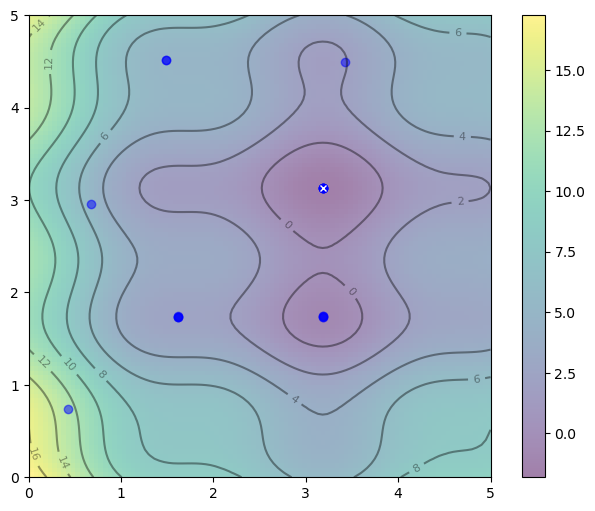

DPSO found best solution at f([3.18513294 3.1296845 ])=-1.8083519095302056


In [7]:
# Plotting and Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

def animate(i):
    ax.clear()
    ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
    ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
    contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
    ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
    for pos in positions:
        p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
    nbest_plot.set_offsets(nbest.reshape(1, -1))
    return ax, p_plot, nbest_plot

anim = FuncAnimation(fig, animate, frames=len(positions[0]), interval=500, blit=False, repeat=True)
anim.save("PSO.gif", dpi=120, writer="imagemagick")
plt.show()

print("DPSO found best solution at f({})={}".format(nbest, nbest_obj))


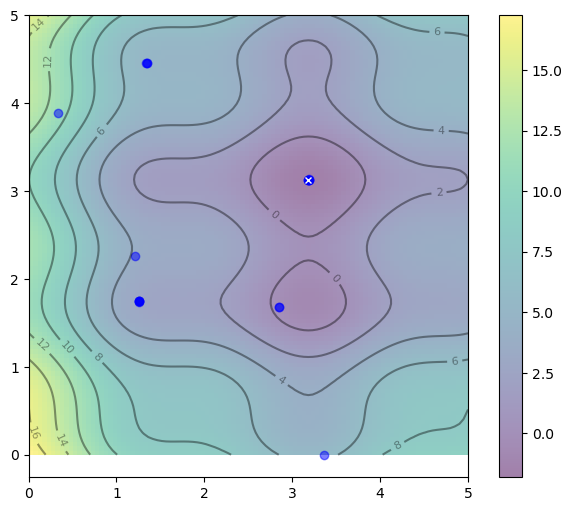

In [8]:
# Plotting - no Animation
x, y = np.array(np.meshgrid(np.linspace(0, 5, 100), np.linspace(0, 5, 100)))
z = f(x, y)
x_min, y_min = x.ravel()[z.argmin()], y.ravel()[z.argmin()]

fig, ax = plt.subplots(figsize=(8, 6))
img = ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
p_plot = ax.scatter(positions[0][0], positions[0][1], marker='o', color='blue', alpha=0.5)
nbest_plot = plt.scatter([nbest[0]], [nbest[1]], marker='*', s=100, color='black', alpha=0.4)

i = 50
ax.clear()
ax.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
for pos in positions:
    p_plot = ax.scatter(pos[i][0], pos[i][1], marker='o', color='blue', alpha=0.5)
nbest_plot.set_offsets(nbest.reshape(1, -1))
plt.show()